<a href="https://colab.research.google.com/github/mardocheeogecime-gif/Rede_Colabora-o_Acad-mica_ECI_UFMG/blob/main/Rede_Colabora%C3%A7%C3%A3o_ECI_UFMG_Otimiza%C3%A7%C3%A3o_Multi_objetivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
Using cached setuptools-75.8.0-py3-none-any.whl (1.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do th

/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


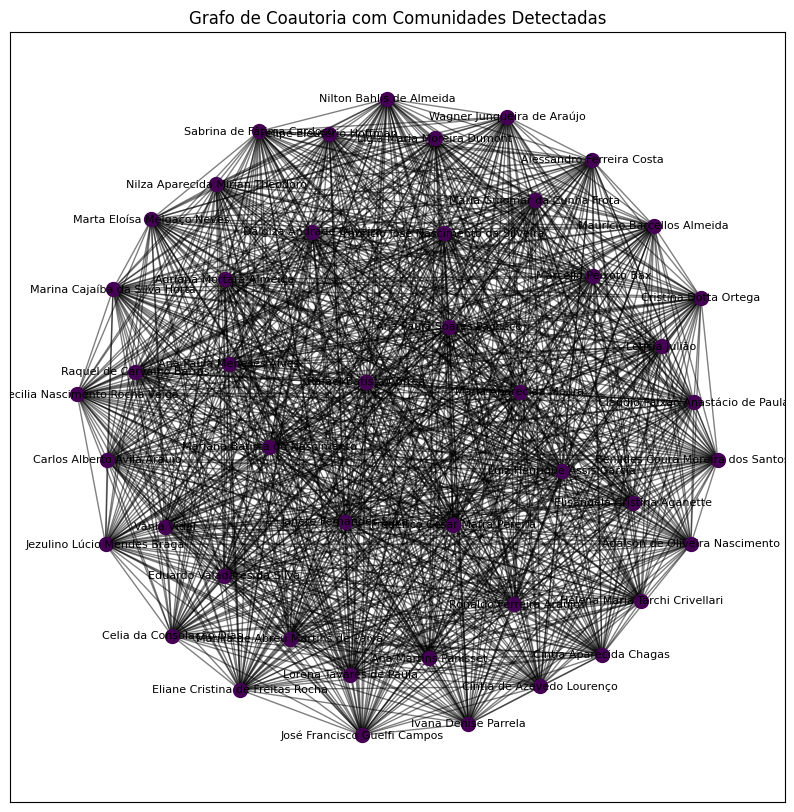

In [ ]:
# Instalação das bibliotecas necessárias
!pip install PyMuPDF transformers torch spacy networkx matplotlib python-louvain fuzzywuzzy[speedup]
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz
!python -m spacy download pt_core_news_sm

# Importação das bibliotecas
import fitz  # PyMuPDF para manipulação de PDFs
import spacy
import os
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from networkx.drawing.nx_agraph import graphviz_layout
import community.community_louvain as community_louvain  # para detecção de comunidades
from fuzzywuzzy import process, fuzz  # fuzzy matching
from collections import Counter
import re
import time
from networkx.algorithms.community import girvan_newman
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho para a pasta com os currículos no Google Drive
caminho_curriculos = '/content/drive/My Drive/curriculos/'

# Carregar o modelo em português do spaCy
nlp = spacy.load('pt_core_news_sm')

# Carregar o tokenizer e modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Dicionário com nomes completos e citações bibliográficas
citacoes_bibliograficas = {
    "Adalson de Oliveira Nascimento": ["NASCIMENTO, A. O."],
    "Adriana Mortara Almeida": ["ALMEIDA, A. M.", "ALMEIDA, ADRIANA", "ALMEIDA, ADRIANA MORTARA"],
    "Alessandro Ferreira Costa": ["COSTA, Alessandro Ferreira"],
    "Ana Cecilia Nascimento Rocha Veiga": ["VEIGA, Ana Cecília Rocha", "ROCHA VEIGA, Ana Cecília", "ROCHA, Ana Cecília"],
    "Ana Martins Panisset": ["PANISSET, Ana M.", "PANISSET, Ana"],
    "Ana Paula Meneses Alves": ["ALVES, A. P. M."],
    "Ana Paula Soares Pacheco": ["PACHECO, A. P. S."],
    "Benildes Coura Moreira dos Santos Maculan": ["MACULAN, B. C. M. S.", "MACULAN, Benildes C. M. S.", "MACULAN, Benildes Coura", "MACULAN, Benildes C. M. dos S.", "MACULAN, BENILDES COURA MOREIRA DOS SANTOS", "MOREIRA DOS SANTOS MACULAN, BENILDES COURA", "Maculan, Benildes", "MACULAN, BENILDES C. M. S.", "COURA MOREIRA DOS SANTOS MACULAN, BENILDES", "MACULAN, BENILDES COURA M. S.", "MACULAN, BENILDES COURA DOS SANTOS"],
    "Carlos Alberto Avila Araujo": ["ARAUJO, C. A. A.", "ARAÚJO, C. A. Á.", "ARAÚJO, CARLOS ALBERTO ÁVILA", "ÁVILA ARAÚJO, CARLOS ALBERTO", "ARAÚJO, CARLOS 'ALBERTO' ÁVILA"],
    "Celia da Consolação Dias": ["DIAS, Célia C.", "Dias, Célia da Consolação", "DIAS, CÉLIA CONSOLAÇÃO", "DA CONSOLAÇÃO DIAS, CÉLIA"],
    "Cintia Aparecida Chagas": ["ARREGUY, Cintia A. C.", "CHAGAS, Cintia A.", "CHAGAS, CINTIA APARECIDA"],
    "Cíntia de Azevedo Lourenço": ["LOURENÇO, C. A.", "LOURENÇO, CÍNTIA DE AZEVEDO", "LOURENÇO, CINTIA AZEVEDO", "DE AZEVEDO LOURENÇO, CÍNTIA", "LOURENÇO, CÍNTIA DE AZEVEDO"],
    "Claudio Paixão Anastácio de Paula": ["PAULA, Claudio Paixão Anastácio de", "PAULA, CLAUDIO PAIXÃO ANASTÁCIO DE", "PAULA, CLÁUDIO PAIXÃO ANASTÁCIO DE", "PAULA, O ANASTÁCIO DE", "PAULA, C. P. A.", "PAIXÃO ANASTÁCIO DE PAULA, CLÁUDIO"],
    "Cristina Dotta Ortega": ["ORTEGA, C. D.", "ORTEGA, CRISTINA DOTTA"],
    "Dalgiza Andrade Oliveira": ["OLIVEIRA, D. A.", "OLIVEIRA, DALGIZA ANDRADE", "ANDRADE OLIVEIRA, DALGIZA"],
    "Eduardo Valadares da Silva": ["SILVA, E. V."],
    "Eliane Cristina de Freitas Rocha": ["ROCHA, E. C. F.", "ROCHA, ELIANE CRISTINA DE FREITAS"],
    "Elisângela Cristina Aganette": ["AGANETTE, ELISÂNGELA CRISTINA", "AGANETTE, E. C.", "AGANETTE, ELISANGELA CRISTINA"],
    "Fabrício José Nascimento da Silveira": ["SILVEIRA, F. J. N.", "SILVEIRA, FABRÍCIO JOSÉ NASCIMENTO DA"],
    "Felipe Eleutério Hoffman": ["HOFFMAN, F. E.", "HOFFMAN, FELIPE ELEUTÉRIO"],
    "Frederico Cesar Mafra Pereira": ["MAFRA PEREIRA, Frederico Cesar", "PEREIRA, Frederico Cesar Mafra", "PEREIRA, FREDERICO CÉSAR MAFRA", "MAFRA PEREIRA, FREDERICO CÉSAR"],
    "Helena Maria Tarchi Crivellari": ["CRIVELLARI, H. M. T.", "CRIVELLARI, Helena", "CRIVELLARI, H.", "CRIVELLARI, HELENA MARIA TARCHI"],
    "Ivana Denise Parrela": ["PARRELA, Ivana D."],
    "Janete Fernandes Silva": ["SILVA, J. F.", "Silva, Janete Fernandes"],
    "Jezulino Lúcio Mendes Braga": ["BRAGA, J. L. M.", "BRAGA, JEZULINO LÚCIO MENDES"],
    "José Francisco Guelfi Campos": ["CAMPOS, José Francisco Guelfi", "CAMPOS, JOSÉ FRANCISCO GUELFI"],
    "Letícia Julião": ["JULIÃO, Letícia", "Julião, L."],
    "Ligia Maria Moreira Dumont": ["DUMONT, L. M. M.", "DUMONT, LÍGIA MARIA MOREIRA", "DUMONT, LIGIA MARIA MOREIRA"],
    "Lorena Tavares de Paula": ["PAULA, L. T.", "PAULA, LORENA TAVARES DE"],
    "Luiz Henrique Assis Garcia": ["GARCIA, Luiz Henrique A.", "GARCIA, LUIZ HENRIQUE ASSIS", "Luiz Henrique Assis Garcia", "GARCIA, L. H. A."],
    "Marcello Peixoto Bax": ["BAX, M. P.", "BAX, MARCELLO PEIXOTO", "BAX, MARCELLO P.", "PEIXOTO BAX, MARCELLO"],
    "Maria Aparecida Moura": ["MOURA, M. A.", "Moura, Maria Aparecida"],
    "Maria Guiomar da Cunha Frota": ["FROTA, Maria Guiomar da Cunha", "FROTA, MARIA GUIOMAR DA CUNHA", "Guiomar Frota, Maria"],
    "Mariana Batista do Nascimento": ["NASCIMENTO, M. B.", "NASCIMENTO, MARIANA BATISTA DO"],
    "Marília de Abreu Martins de Paiva": ["PAIVA, Marília de Abreu Martins", "PAIVA, MARÍLIA DE ABREU MARTINS DE", "PAIVA, MARILIA DE ABREU MARTINS DE", "DE ABREU MARTINS DE PAIVA, MARÍLIA", "PAIVA, Marilia de A. M. de", "PAIVA, Marilia", "PAIVA, MARÍLIA DE A. M. DE"],
    "Marina Cajaíba da Silva Horta": ["SILVA, Marina Cajaíba", "HORTA, Marina Cajaíba da Silva"],
    "Marta Eloísa Melgaço Neves": ["NEVES, M. E. M.", "NEVES, MARTA ELOÍSA MELGAÇO", "NEVES, MARTA ELOÍSA MELGAÇO"],
    "Maurício Barcellos Almeida": ["ALMEIDA, M. B.", "BARCELLOS ALMEIDA, MAURÍCIO", "ALMEIDA, MAURÍCIO BARCELLOS"],
    "Nilton Bahlis de Almeida": ["ALMEIDA, Nilton Bahlis", "ALMEIDA, NILTON BAHLIS"],
    "Nilza Aparecida Mirian Theodoro": ["THEODORO, Nilza A. M.", "THEODORO, NILZA APARECIDA MIRIAN", "THEODORO, NILZA APARECIDA MIRIAN", "MIRIAN THEODORO, NILZA APARECIDA"],
    "Rafael Batista Corrêa": ["CORRÊA, Rafael Batista", "CORRÊA, RAFAEL BATISTA"],
    "Raquel de Carvalho Barros": ["BARROS, Raquel de Carvalho", "BARROS, RAQUEL DE CARVALHO"],
    "Ronaldo Ferreira Araújo": ["ARAÚJO, Ronaldo Ferreira", "ARAÚJO, RONALDO FERREIRA"],
    "Sabrina de Fátima Cardoso": ["CARDOSO, Sabrina de Fátima", "CARDOSO, SABRINA DE FÁTIMA"],
    "Vânia Vidal": ["VIDAL, Vânia", "VIDAL, VÂNIA"],
    "Wagner Junqueira de Araújo": ["ARAÚJO, Wagner Junqueira de", "ARAÚJO, WAGNER JUNQUEIRA DE"]
}

# Função para extrair texto dos PDFs
def extrair_texto_pdf(caminho):
    documento = fitz.open(caminho)
    texto = ""
    for pagina in documento:
        texto += pagina.get_text()
    return texto

# Função para identificar nomes mencionados no texto usando fuzzy matching
def identificar_nomes_fuzzy(texto, citacoes_bibliograficas):
    nomes_mencionados = set()
    for nome_completo, citacoes in citacoes_bibliograficas.items():
        for citacao in citacoes:
            # Realiza o matching fuzzy com a citação bibliográfica
            resultado = process.extractOne(citacao, texto.split(), scorer=fuzz.token_set_ratio)
            if resultado and resultado[1] > 85:  # Threshold de 85% de similaridade
                nomes_mencionados.add(nome_completo)
                break
    return nomes_mencionados

# Função para gerar embeddings usando BERTimbau
def gerar_embeddings(textos):
    inputs = tokenizer(textos, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# Função para criar o grafo de coautoria
def criar_grafo_coautoria(relacoes):
    grafo = nx.Graph()
    for autores in relacoes:
        for i in range(len(autores)):
            for j in range(i + 1, len(autores)):
                if grafo.has_edge(autores[i], autores[j]):
                    grafo[autores[i]][autores[j]]['weight'] += 1
                else:
                    grafo.add_edge(autores[i], autores[j], weight=1)
    return grafo

# Função para detectar comunidades usando o algoritmo de Girvan-Newman
def detectar_comunidades_girvan_newman(grafo, num_comunidades):
    comp = girvan_newman(grafo)
    comunidades = []
    for comunidades_level in comp:
        comunidades.append(sorted(map(sorted, comunidades_level)))
        if len(comunidades) >= num_comunidades:
            break
    return comunidades[-1]

# Função para detectar comunidades usando o algoritmo de Louvain
def detectar_comunidades_louvain(grafo):
    particao = community_louvain.best_partition(grafo)
    comunidades = {}
    for no, com in particao.items():
        if com not in comunidades:
            comunidades[com] = []
        comunidades[com].append(no)
    return list(comunidades.values()), particao

# Função para plotar o grafo com as comunidades detectadas
def plotar_grafo(grafo, particao):
    pos = graphviz_layout(grafo, prog="neato")
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_edges(grafo, pos, alpha=0.5)
    cmap = plt.get_cmap('viridis')
    for com in set(particao.values()):
        lista_nos = [no for no in particao if particao[no] == com]
        nx.draw_networkx_nodes(grafo, pos, lista_nos, node_size=100, node_color=[cmap(com / len(set(particao.values())))])

    nx.draw_networkx_labels(grafo, pos, font_size=8, font_color="black")
    plt.title('Grafo de Coautoria com Comunidades Detectadas')
    plt.show()

# Função para processar currículos e construir o grafo de coautoria
def processar_curriculos(caminho_curriculos):
    relacoes = []
    for arquivo in os.listdir(caminho_curriculos):
        if arquivo.endswith(".pdf"):
            caminho = os.path.join(caminho_curriculos, arquivo)
            texto = extrair_texto_pdf(caminho)
            nomes_mencionados = identificar_nomes_fuzzy(texto, citacoes_bibliograficas)
            if nomes_mencionados:
                relacoes.append(list(nomes_mencionados))
    return relacoes

# Processar currículos e construir o grafo
relacoes = processar_curriculos(caminho_curriculos)
grafo_coautoria = criar_grafo_coautoria(relacoes)

# Detectar comunidades com Louvain
comunidades, particao = detectar_comunidades_louvain(grafo_coautoria)

# Plotar o grafo de coautoria com as comunidades
plotar_grafo(grafo_coautoria, particao)

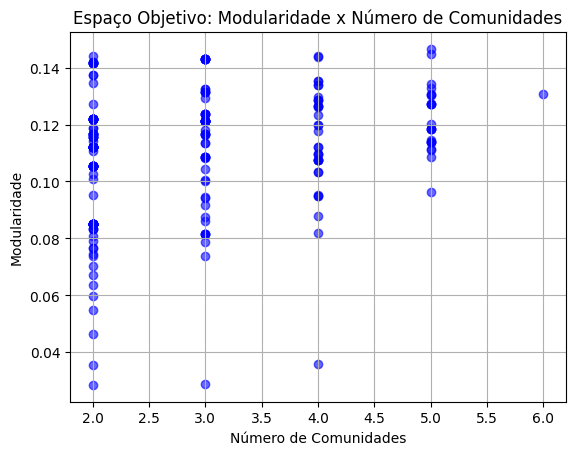

Solução 1: Modularidade = 0.0285, Número de Comunidades = 2
Solução 2: Modularidade = 0.0288, Número de Comunidades = 3
Solução 3: Modularidade = 0.0357, Número de Comunidades = 2
Solução 4: Modularidade = 0.0358, Número de Comunidades = 4
Solução 5: Modularidade = 0.0464, Número de Comunidades = 2
Solução 6: Modularidade = 0.0549, Número de Comunidades = 2
Solução 7: Modularidade = 0.0596, Número de Comunidades = 2
Solução 8: Modularidade = 0.0637, Número de Comunidades = 2
Solução 9: Modularidade = 0.0672, Número de Comunidades = 2
Solução 10: Modularidade = 0.0704, Número de Comunidades = 2
Solução 11: Modularidade = 0.0738, Número de Comunidades = 2
Solução 12: Modularidade = 0.0739, Número de Comunidades = 3
Solução 13: Modularidade = 0.0787, Número de Comunidades = 3
Solução 14: Modularidade = 0.0744, Número de Comunidades = 2
Solução 15: Modularidade = 0.0767, Número de Comunidades = 2
Solução 16: Modularidade = 0.0814, Número de Comunidades = 3
Solução 17: Modularidade = 0.0767

In [ ]:
# Importação das bibliotecas necessárias
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain  # Louvain para detecção de comunidades

# Função para criar uma partição inicial diversificada
def gerar_particao_inicial(rede, max_comunidades=7):
    qtd_comunidades = random.randint(2, max_comunidades)
    return {no: random.randint(0, qtd_comunidades - 1) for no in rede.nodes()}

# Função para calcular modularidade e número de comunidades
def calcular_modularidade_comunidades(rede, particao):
    modularidade = community_louvain.modularity(particao, rede)
    numero_comunidades = len(set(particao.values()))
    return modularidade, numero_comunidades

# Função de dominância para NSGA-II
def verificar_dominancia(avaliacao1, avaliacoes2):
    mod1, com1 = avaliacao1
    mod2, com2 = avaliacoes2
    return (mod1 > mod2 and com1 <= com2) or (mod1 >= mod2 and com1 < com2)

# Inicializar população de soluções
def inicializar_solucoes(rede, tamanho_pop, max_comunidades=7):
    if tamanho_pop < 2:
        raise ValueError("O tamanho da população deve ser pelo menos 2.")
    populacao = []
    avaliacoes = []
    for _ in range(tamanho_pop):
        particao = gerar_particao_inicial(rede, max_comunidades)
        populacao.append(particao)
        avaliacoes.append(calcular_modularidade_comunidades(rede, particao))
    return populacao, avaliacoes

# Operador de mutação para maior diversidade
def aplicar_mutacao(particao, max_comunidades=7):
    no = random.choice(list(particao.keys()))
    nova_comunidade = random.randint(0, max_comunidades - 1)
    nova_particao = particao.copy()
    nova_particao[no] = nova_comunidade
    return nova_particao

# Seleção por torneio
def selecionar_por_torneio(populacao, avaliacoes):
    if len(populacao) < 2:
        return random.choice(populacao)  # Retorna uma solução aleatória se a população for insuficiente
    i, j = random.sample(range(len(populacao)), 2)  # Seleção de dois índices aleatórios
    if verificar_dominancia(avaliacoes[i], avaliacoes[j]):
        return populacao[i]
    return populacao[j]

# Seleção de não-dominados
def obter_nao_dominados(populacao, avaliacoes, tamanho_maximo):
    nao_dominados = []
    indices = []
    for i, aval in enumerate(avaliacoes):
        dominado = False
        for j, outro_aval in enumerate(avaliacoes):
            if i != j and verificar_dominancia(outro_aval, aval):
                dominado = True
                break
        if not dominado:
            nao_dominados.append(populacao[i])
            indices.append(i)
    if len(indices) > tamanho_maximo:
        indices = random.sample(indices, tamanho_maximo)
    nao_dominados = [populacao[i] for i in indices]
    avaliacoes_nao_dominadas = [avaliacoes[i] for i in indices]
    return nao_dominados, avaliacoes_nao_dominadas

# Algoritmo NSGA-II
def executar_nsga_ii(rede, tamanho_pop=50, max_geracoes=50, max_comunidades=7):
    populacao, avaliacoes = inicializar_solucoes(rede, tamanho_pop, max_comunidades)
    historico = []  # Armazenar histórico das avaliações
    for _ in range(max_geracoes):
        nova_populacao = []
        for _ in range(tamanho_pop):
            pai = selecionar_por_torneio(populacao, avaliacoes)
            filho = aplicar_mutacao(pai, max_comunidades)
            nova_populacao.append(filho)
        nova_avaliacoes = [calcular_modularidade_comunidades(rede, part) for part in nova_populacao]
        populacao.extend(nova_populacao)
        avaliacoes.extend(nova_avaliacoes)
        populacao, avaliacoes = obter_nao_dominados(populacao, avaliacoes, tamanho_pop)
        historico.extend(avaliacoes)
    return populacao, historico

# Visualização do espaço objetivo
def visualizar_espaco_objetivo(avaliacoes):
    modularidades = [aval[0] for aval in avaliacoes]
    comunidades = [aval[1] for aval in avaliacoes]
    plt.scatter(comunidades, modularidades, c='blue', alpha=0.6)
    plt.title("Espaço Objetivo: Modularidade x Número de Comunidades")
    plt.xlabel("Número de Comunidades")
    plt.ylabel("Modularidade")
    plt.grid(True)
    plt.show()

# Exemplo de integração com o grafo existente
grafo_exemplo = nx.barabasi_albert_graph(100, 5)
populacao_final, avaliacoes_final = executar_nsga_ii(
    grafo_exemplo, tamanho_pop=50, max_geracoes=50, max_comunidades=7
)

# Visualizar resultados
visualizar_espaco_objetivo(avaliacoes_final)

# Diagnóstico: Exibir soluções
for idx, (mod, com) in enumerate(avaliacoes_final):
    print(f"Solução {idx + 1}: Modularidade = {mod:.4f}, Número de Comunidades = {com}")

In [ ]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain

def criar_particao_inicial(grafo):
    """Cria uma partição inicial aleatória para o grafo."""
    num_comunidades = random.randint(2, 5)
    return {no: random.randint(0, num_comunidades - 1) for no in grafo.nodes()}

def avaliar_particao(grafo, particao):
    """Calcula a modularidade e o número de comunidades de uma partição."""
    modularidade = community_louvain.modularity(particao, grafo)
    num_comunidades = len(set(particao.values()))
    return modularidade, num_comunidades

def domina(avaliacao1, avaliacao2):
    """Verifica se a avaliação1 domina a avaliação2."""
    modularidade1, comunidades1 = avaliacao1
    modularidade2, comunidades2 = avaliacao2
    return (modularidade1 > modularidade2 and comunidades1 <= comunidades2) or \
           (modularidade1 >= modularidade2 and comunidades1 < comunidades2)

def inicializar_populacao(grafo, tamanho_pop):
    """Inicializa a população com partições aleatórias."""
    populacao = [criar_particao_inicial(grafo) for _ in range(tamanho_pop)]
    avaliacoes = [avaliar_particao(grafo, particao) for particao in populacao]
    return populacao, avaliacoes

def mutar_particao(particao):
    """Aplica mutação em uma partição."""
    no = random.choice(list(particao.keys()))
    nova_comunidade = random.randint(0, max(particao.values()) + 1)
    nova_particao = particao.copy()
    nova_particao[no] = nova_comunidade
    return nova_particao

def selecao_torneio(populacao, avaliacoes):
    """Realiza a seleção por torneio."""
    i, j = random.sample(range(len(populacao)), 2)
    return populacao[i] if domina(avaliacoes[i], avaliacoes[j]) else populacao[j]

# Seleção de não-dominados
def selecionar_nao_dominados(populacao, avaliacoes, tamanho_pop):
    nao_dominados = []
    indices = []
    for i, aval in enumerate(avaliacoes):
        dominado = False
        for j, outro_aval in enumerate(avaliacoes):
            if i != j and domina(outro_aval, aval):
                dominado = True
                break
        if not dominado:
            nao_dominados.append(populacao[i])
            indices.append(i)

    # Garantir que a população de não-dominados não exceda o tamanho desejado
    if len(nao_dominados) > tamanho_pop:
        indices = random.sample(indices, tamanho_pop)
        nao_dominados = [populacao[i] for i in indices]
        avaliacoes_nao_dominadas = [avaliacoes[i] for i in indices]
    else:
        avaliacoes_nao_dominadas = [avaliacoes[i] for i in indices]

    # Garantir que a população tenha pelo menos `tamanho_pop` indivíduos
    while len(nao_dominados) < tamanho_pop:
        # Adiciona indivíduos aleatórios se necessário
        novo_individuo = criar_particao_inicial(populacao[0].keys())
        nao_dominados.append(novo_individuo)
        avaliacoes_nao_dominadas.append(avaliar_particao(populacao[0], novo_individuo))

    return nao_dominados, avaliacoes_nao_dominadas

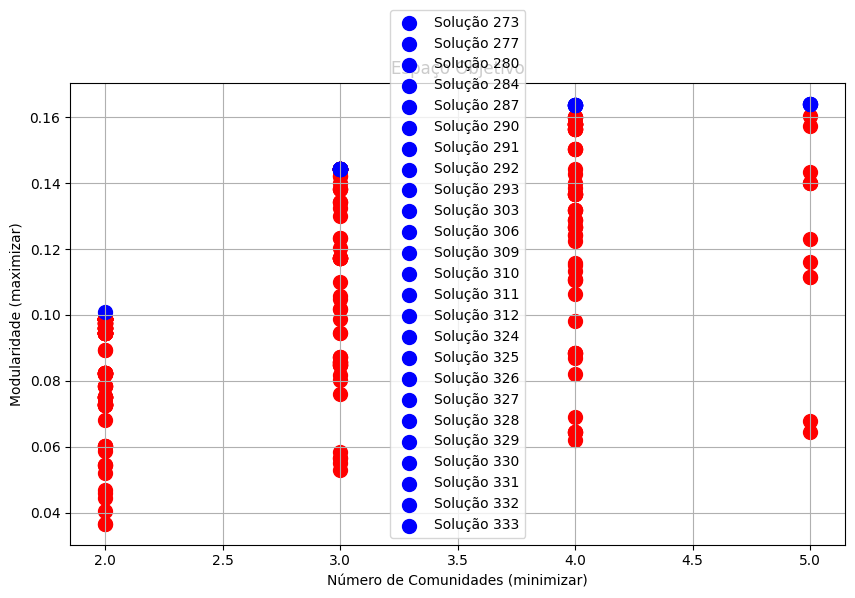

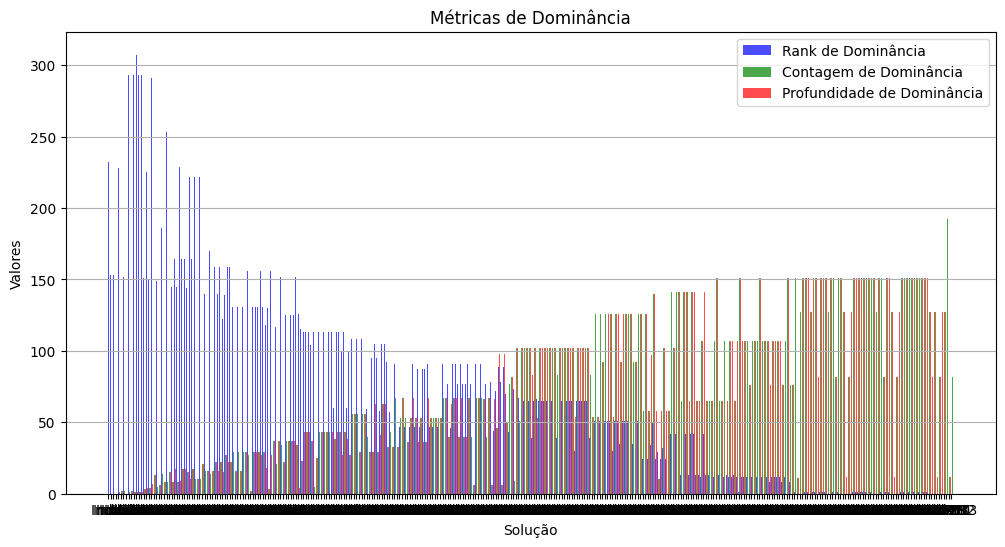

In [ ]:
import matplotlib.pyplot as plt

# Função para calcular métricas de dominância
def calcular_metricas_dominancia(avaliacoes):
    n = len(avaliacoes)
    rank_dominancia = [0] * n  # Hierarquia de Dominância
    count_dominancia = [0] * n  # Contagem de Dominância
    depth_dominancia = [0] * n  # Profundidade de Dominância

    dominancia = [[] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i != j:
                # Comparação de dominância
                if (avaliacoes[i][0] >= avaliacoes[j][0] and  # Maximizar modularidade
                    avaliacoes[i][1] <= avaliacoes[j][1] and  # Minimizar número de comunidades
                    (avaliacoes[i][0] > avaliacoes[j][0] or avaliacoes[i][1] < avaliacoes[j][1])):
                    dominancia[i].append(j)
                    count_dominancia[i] += 1

    # Calcular hierarquia e profundidade
    for i, dominados in enumerate(dominancia):
        for dominado in dominados:
            rank_dominancia[dominado] += 1
        depth_dominancia[i] = len(dominancia[i])

    # Encontrar soluções não dominadas
    nao_dominados = [i for i in range(n) if rank_dominancia[i] == 0]

    return rank_dominancia, count_dominancia, depth_dominancia, nao_dominados

# Função para plotar o espaço objetivo
def plot_espaco_objetivo(avaliacoes, rank_dominancia, nao_dominados):
    plt.figure(figsize=(10, 6))
    cores = ['blue' if i in nao_dominados else 'red' for i in range(len(avaliacoes))]

    for i, (modularidade, comunidades) in enumerate(avaliacoes):
        plt.scatter(comunidades, modularidade, color=cores[i], label=f'Solução {i}' if i in nao_dominados else "", s=100)

    plt.xlabel("Número de Comunidades (minimizar)")
    plt.ylabel("Modularidade (maximizar)")
    plt.title("Espaço Objetivo")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Função para plotar métricas de dominância
def plot_metricas_dominancia(rank_dominancia, count_dominancia, depth_dominancia):
    indices = list(range(len(rank_dominancia)))
    largura = 0.3  # Largura das barras

    plt.figure(figsize=(12, 6))
    plt.bar(indices, rank_dominancia, width=largura, label="Rank de Dominância", color='blue', alpha=0.7)
    plt.bar([i + largura for i in indices], count_dominancia, width=largura, label="Contagem de Dominância", color='green', alpha=0.7)
    plt.bar([i + 2 * largura for i in indices], depth_dominancia, width=largura, label="Profundidade de Dominância", color='red', alpha=0.7)

    plt.xlabel("Solução")
    plt.ylabel("Valores")
    plt.title("Métricas de Dominância")
    plt.xticks(indices, [f"Ind {i}" for i in indices])
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Calcular as métricas de dominância
rank_dominancia, count_dominancia, depth_dominancia, nao_dominados = calcular_metricas_dominancia(avaliacoes_final)

# Chamadas de plotagem
plot_espaco_objetivo(avaliacoes_final, rank_dominancia, nao_dominados)
plot_metricas_dominancia(rank_dominancia, count_dominancia, depth_dominancia)

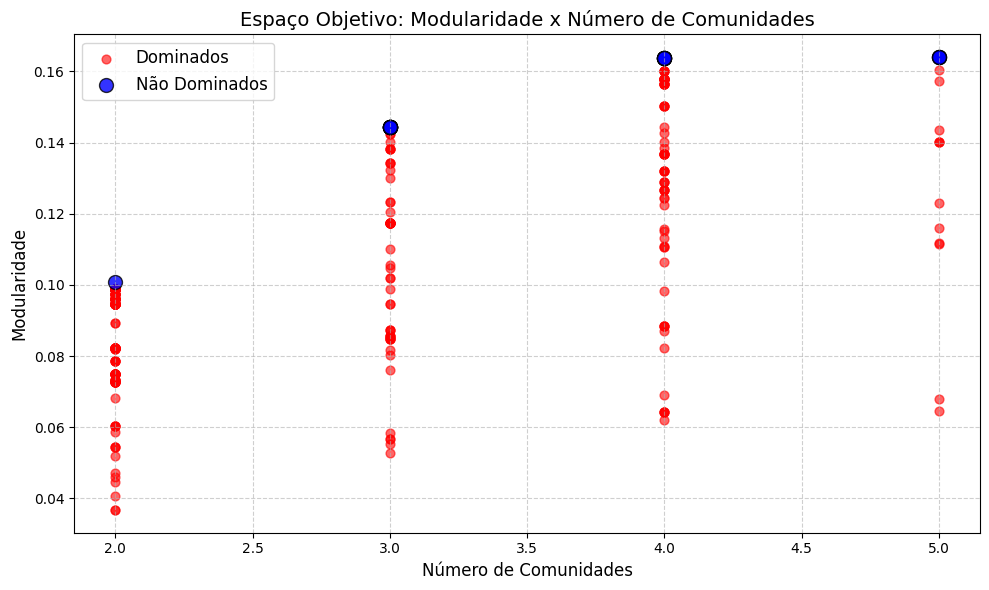

In [ ]:
def plotar_espaco_objetivo_com_legendas(avaliacoes):
    modularidades = [aval[0] for aval in avaliacoes]
    num_comunidades = [aval[1] for aval in avaliacoes]

    # Identificar pontos não dominados
    indices_nao_dominados = []
    for i, aval in enumerate(avaliacoes):
        dominado = False
        for j, outro_aval in enumerate(avaliacoes):
            if i != j and domina(outro_aval, aval):
                dominado = True
                break
        if not dominado:
            indices_nao_dominados.append(i)

    # Separar pontos dominados e não dominados
    modularidades_nao_dominados = [modularidades[i] for i in indices_nao_dominados]
    num_comunidades_nao_dominados = [num_comunidades[i] for i in indices_nao_dominados]

    modularidades_dominados = [modularidades[i] for i in range(len(modularidades)) if i not in indices_nao_dominados]
    num_comunidades_dominados = [num_comunidades[i] for i in range(len(num_comunidades)) if i not in indices_nao_dominados]

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.scatter(num_comunidades_dominados, modularidades_dominados, c='red', label='Dominados', alpha=0.6, s=40)
    plt.scatter(num_comunidades_nao_dominados, modularidades_nao_dominados, c='blue', label='Não Dominados', alpha=0.8, s=100, edgecolor='black')

    # Configurações do gráfico
    plt.title("Espaço Objetivo: Modularidade x Número de Comunidades", fontsize=14)
    plt.xlabel("Número de Comunidades", fontsize=12)
    plt.ylabel("Modularidade", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()

# Plotar resultados aprimorados
plotar_espaco_objetivo_com_legendas(avaliacoes_final)

Avaliações: [(0.0633, 2), (0.07, 2), (0.0738, 2), (0.1147, 2), (0.0743, 3), (0.1193, 3), (0.1204, 3), (0.1244, 3)]

Índices Pareto-ótimos: [3, 7]

Estatísticas descritivas para soluções Pareto-ótimas:
Modularidade:
  Média: 0.1195
  Desvio Padrão: 0.0049
  Mediana: 0.1195
Número de Comunidades:
  Média: 2.5000
  Desvio Padrão: 0.5000
  Mediana: 2.5000


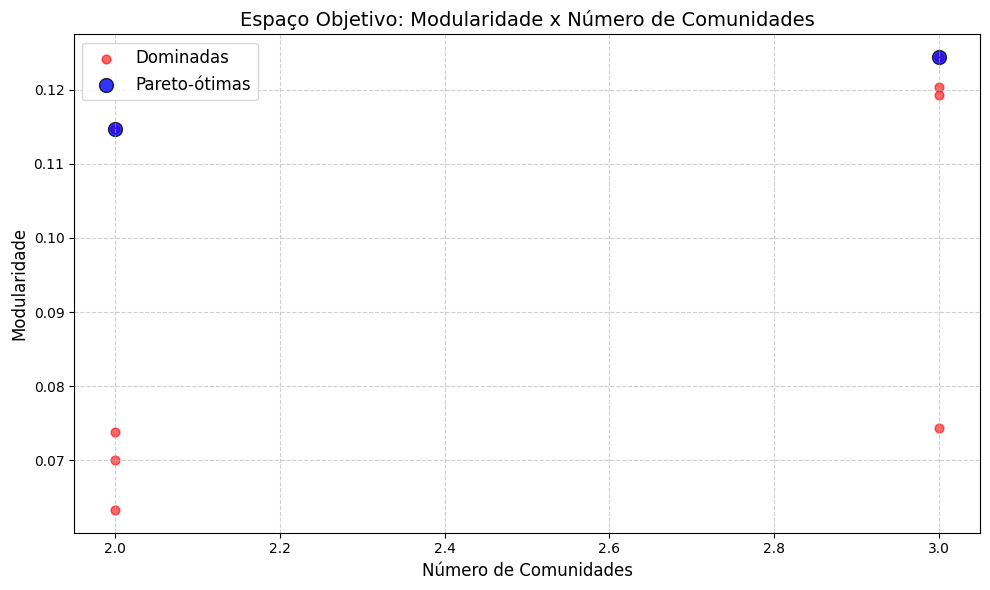


Comparação de soluções:
Solução 0: Modularidade = 0.0633, Comunidades = 2 -> Dominada
Solução 1: Modularidade = 0.0700, Comunidades = 2 -> Dominada
Solução 2: Modularidade = 0.0738, Comunidades = 2 -> Dominada
Solução 3: Modularidade = 0.1147, Comunidades = 2 -> Pareto-ótima
Solução 4: Modularidade = 0.0743, Comunidades = 3 -> Dominada
Solução 5: Modularidade = 0.1193, Comunidades = 3 -> Dominada
Solução 6: Modularidade = 0.1204, Comunidades = 3 -> Dominada
Solução 7: Modularidade = 0.1244, Comunidades = 3 -> Pareto-ótima


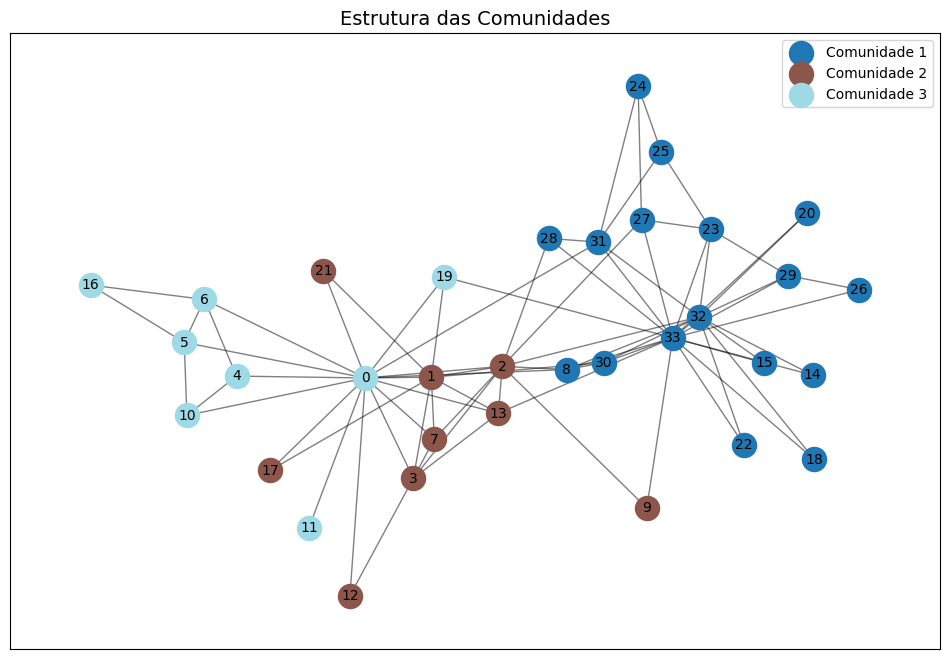


Métricas adicionais:
Modularidade: 0.4110
Índice de Silhueta: -0.9640
Densidade Global: 0.1390


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import silhouette_score

# Função para verificar dominância (Pareto)
def domina(solucao1, solucao2):
    """Verifica se uma solução domina outra.
    Maximiza modularidade (índice 0) e minimiza número de comunidades (índice 1).
    """
    return all(s1 >= s2 if i == 0 else s1 <= s2 for i, (s1, s2) in enumerate(zip(solucao1, solucao2))) and \
           any(s1 > s2 if i == 0 else s1 < s2 for i, (s1, s2) in enumerate(zip(solucao1, solucao2)))

# Função para identificar soluções Pareto-ótimas
def obter_solucoes_pareto(avaliacoes):
    """Identifica os índices das soluções Pareto-ótimas."""
    nao_dominados = []
    for i, sol in enumerate(avaliacoes):
        dominado = False
        for j, outra_sol in enumerate(avaliacoes):
            if i != j and domina(outra_sol, sol):
                dominado = True
                break
        if not dominado:
            nao_dominados.append(i)
    return nao_dominados

# Função para calcular estatísticas descritivas
def estatisticas_pareto(avaliacoes, indices_pareto):
    """Calcula estatísticas descritivas para as soluções Pareto-ótimas."""
    pareto_solucoes = [avaliacoes[i] for i in indices_pareto]
    modularidades = [sol[0] for sol in pareto_solucoes]
    num_comunidades = [sol[1] for sol in pareto_solucoes]

    estatisticas = {
        "Modularidade": {
            "Média": np.mean(modularidades),
            "Desvio Padrão": np.std(modularidades),
            "Mediana": np.median(modularidades),
        },
        "Número de Comunidades": {
            "Média": np.mean(num_comunidades),
            "Desvio Padrão": np.std(num_comunidades),
            "Mediana": np.median(num_comunidades),
        },
    }
    return estatisticas

# Função para plotar o espaço objetivo
def plotar_espaco_objetivo(avaliacoes, indices_pareto):
    """Plota o espaço objetivo com destaque para soluções Pareto-ótimas."""
    modularidades = [aval[0] for aval in avaliacoes]
    num_comunidades = [aval[1] for aval in avaliacoes]
    modularidades_pareto = [modularidades[i] for i in indices_pareto]
    num_comunidades_pareto = [num_comunidades[i] for i in indices_pareto]

    plt.figure(figsize=(10, 6))
    plt.scatter(num_comunidades, modularidades, c='red', label='Dominadas', alpha=0.6, s=40)
    plt.scatter(num_comunidades_pareto, modularidades_pareto, c='blue', label='Pareto-ótimas', alpha=0.8, s=100, edgecolor='black')
    plt.title("Espaço Objetivo: Modularidade x Número de Comunidades", fontsize=14)
    plt.xlabel("Número de Comunidades", fontsize=12)
    plt.ylabel("Modularidade", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    plt.show()

# Função para calcular métricas adicionais de rede
def calcular_metricas_adicionais(grafo, comunidades):
    """Calcula métricas adicionais para a rede."""
    modularidade = nx.algorithms.community.modularity(grafo, comunidades)

    # Preparar rótulos para índice de silhueta
    rótulos = np.zeros(grafo.number_of_nodes())
    for i, comunidade in enumerate(comunidades):
        for nó in comunidade:
            rótulos[nó] = i

    # Calcular índice de silhueta
    matriz_distancias = np.array(list(nx.to_numpy_array(grafo)))
    silhueta = silhouette_score(matriz_distancias, rótulos, metric='precomputed')

    # Calcular densidade global
    densidade = nx.density(grafo)

    return {
        "Modularidade": modularidade,
        "Índice de Silhueta": silhueta,
        "Densidade Global": densidade
    }

# Função para visualizar comunidades no grafo
def visualizar_comunidades_rede(grafo, comunidades, titulo="Estrutura das Comunidades"):
    """Visualiza as comunidades identificadas no grafo."""
    pos = nx.spring_layout(grafo)
    plt.figure(figsize=(12, 8))
    cores = plt.cm.tab20(np.linspace(0, 1, len(comunidades)))
    for i, comunidade in enumerate(comunidades):
        nx.draw_networkx_nodes(grafo, pos, nodelist=comunidade, node_color=[cores[i]], label=f"Comunidade {i+1}")
    nx.draw_networkx_edges(grafo, pos, alpha=0.5)
    nx.draw_networkx_labels(grafo, pos, font_size=10)
    plt.title(titulo, fontsize=14)
    plt.legend(fontsize=10)
    plt.show()

# Função para comparar soluções
def comparar_solucoes(avaliacoes, indices_pareto):
    """Compara as soluções identificando as dominadas e Pareto-ótimas."""
    print("\nComparação de soluções:")
    for i, sol in enumerate(avaliacoes):
        status = "Pareto-ótima" if i in indices_pareto else "Dominada"
        print(f"Solução {i}: Modularidade = {sol[0]:.4f}, Comunidades = {sol[1]} -> {status}")

# Exemplo de uso
if __name__ == "__main__":
    # Criar o grafo do exemplo
    grafo = nx.karate_club_graph()
    comunidades_exemplo = [list(c) for c in nx.community.greedy_modularity_communities(grafo)]

    # Avaliações reais (modularidade, número de comunidades)
    avaliacoes = [
        (0.0633, 2), (0.0700, 2), (0.0738, 2), (0.1147, 2),
        (0.0743, 3), (0.1193, 3), (0.1204, 3), (0.1244, 3)
    ]

    print("Avaliações:", avaliacoes)

    # Obter soluções Pareto-ótimas
    indices_pareto = obter_solucoes_pareto(avaliacoes)
    print("\nÍndices Pareto-ótimos:", indices_pareto)

    # Estatísticas descritivas
    estatisticas = estatisticas_pareto(avaliacoes, indices_pareto)
    print("\nEstatísticas descritivas para soluções Pareto-ótimas:")
    for metrica, valores in estatisticas.items():
        print(f"{metrica}:")
        for estatistica, valor in valores.items():
            print(f"  {estatistica}: {valor:.4f}")

    # Plotar espaço objetivo
    plotar_espaco_objetivo(avaliacoes, indices_pareto)

    # Comparar soluções
    comparar_solucoes(avaliacoes, indices_pareto)

    # Visualizar comunidades no grafo
    visualizar_comunidades_rede(grafo, comunidades_exemplo)

    # Validar com métricas adicionais
    metricas_adicionais = calcular_metricas_adicionais(grafo, comunidades_exemplo)
    print("\nMétricas adicionais:")
    for metrica, valor in metricas_adicionais.items():
        print(f"{metrica}: {valor:.4f}")

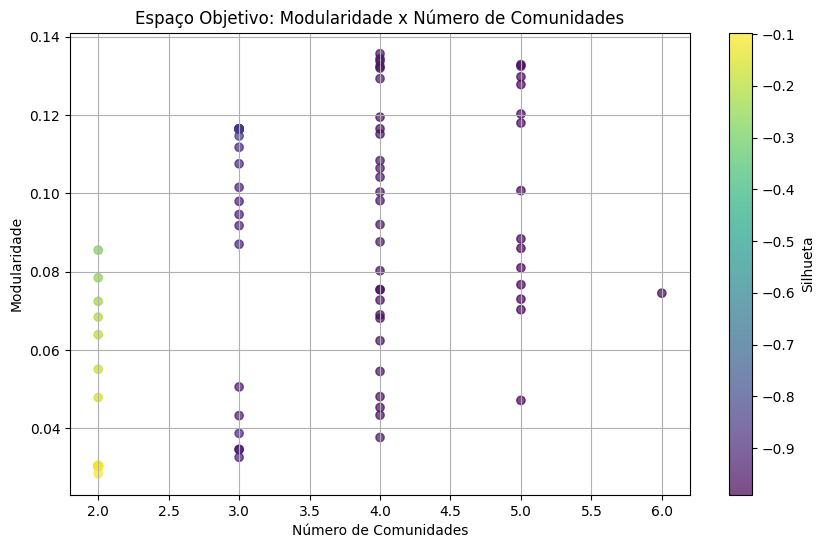

Solução 1: Modularidade = 0.0284, Comunidades = 2, Silhueta = -0.0974
Solução 2: Modularidade = 0.0326, Comunidades = 3, Silhueta = -0.9203
Solução 3: Modularidade = 0.0303, Comunidades = 2, Silhueta = -0.1071
Solução 4: Modularidade = 0.0303, Comunidades = 2, Silhueta = -0.1071
Solução 5: Modularidade = 0.0376, Comunidades = 4, Silhueta = -0.9463
Solução 6: Modularidade = 0.0346, Comunidades = 3, Silhueta = -0.9205
Solução 7: Modularidade = 0.0303, Comunidades = 2, Silhueta = -0.1071
Solução 8: Modularidade = 0.0433, Comunidades = 4, Silhueta = -0.9633
Solução 9: Modularidade = 0.0387, Comunidades = 3, Silhueta = -0.8982
Solução 10: Modularidade = 0.0303, Comunidades = 2, Silhueta = -0.1071
Solução 11: Modularidade = 0.0453, Comunidades = 4, Silhueta = -0.9623
Solução 12: Modularidade = 0.0471, Comunidades = 5, Silhueta = -0.9800
Solução 13: Modularidade = 0.0303, Comunidades = 2, Silhueta = -0.1071
Solução 14: Modularidade = 0.0481, Comunidades = 4, Silhueta = -0.9594
Solução 15: Mod

In [ ]:
# Importação das bibliotecas necessárias
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Função para criar uma partição inicial diversificada
def gerar_particao_inicial(rede, max_comunidades=7):
    qtd_comunidades = random.randint(2, max_comunidades)
    return {no: random.randint(0, qtd_comunidades - 1) for no in rede.nodes()}

# Função para calcular modularidade e número de comunidades
def calcular_modularidade_comunidades(rede, particao):
    modularidade = community_louvain.modularity(particao, rede)
    numero_comunidades = len(set(particao.values()))
    return modularidade, numero_comunidades

# Função para calcular a silhueta
def calcular_silhueta(rede, particao):
    # Converte a particao em um vetor de rótulos
    le = LabelEncoder()
    labels = le.fit_transform(list(particao.values()))

    # Gera a matriz de adjacência do grafo
    matriz_adjacencia = nx.to_numpy_array(rede)

    # Verifica se é possível calcular a silhueta (pelo menos 2 comunidades)
    if len(set(labels)) < 2:
        return -1  # Valor indicativo de que a silhueta não é aplicável

    return silhouette_score(matriz_adjacencia, labels, metric='precomputed')

# Inicialização da população de soluções
def inicializar_solucoes(rede, tamanho_pop, max_comunidades=7):
    if tamanho_pop < 2:
        raise ValueError("O tamanho da população deve ser pelo menos 2.")
    populacao = []
    avaliacoes = []
    for _ in range(tamanho_pop):
        particao = gerar_particao_inicial(rede, max_comunidades)
        modularidade, numero_comunidades = calcular_modularidade_comunidades(rede, particao)
        silhueta = calcular_silhueta(rede, particao)
        populacao.append(particao)
        avaliacoes.append((modularidade, numero_comunidades, silhueta))
    return populacao, avaliacoes

# Função para aplicação de mutação
def aplicar_mutacao(particao, max_comunidades=7):
    no = random.choice(list(particao.keys()))
    nova_comunidade = random.randint(0, max_comunidades - 1)
    nova_particao = particao.copy()
    nova_particao[no] = nova_comunidade
    return nova_particao

# Seleção por torneio
def selecionar_por_torneio(populacao, avaliacoes):
    if len(populacao) < 2:
        return random.choice(populacao)
    i, j = random.sample(range(len(populacao)), 2)
    if avaliacoes[i][0] > avaliacoes[j][0]:
        return populacao[i]
    return populacao[j]

# Seleção de não-dominados
def obter_nao_dominados(populacao, avaliacoes, tamanho_maximo):
    indices_nao_dominados = []
    for i, aval1 in enumerate(avaliacoes):
        dominado = False
        for j, aval2 in enumerate(avaliacoes):
            if i != j and aval2[0] >= aval1[0] and aval2[1] <= aval1[1]:
                dominado = True
                break
        if not dominado:
            indices_nao_dominados.append(i)
    if len(indices_nao_dominados) > tamanho_maximo:
        indices_nao_dominados = random.sample(indices_nao_dominados, tamanho_maximo)
    nova_populacao = [populacao[i] for i in indices_nao_dominados]
    novas_avaliacoes = [avaliacoes[i] for i in indices_nao_dominados]
    return nova_populacao, novas_avaliacoes

# Algoritmo NSGA-II

def executar_nsga_ii(rede, tamanho_pop=50, max_geracoes=50, max_comunidades=7):
    populacao, avaliacoes = inicializar_solucoes(rede, tamanho_pop, max_comunidades)
    historico = []
    for _ in range(max_geracoes):
        nova_populacao = []
        for _ in range(tamanho_pop):
            pai = selecionar_por_torneio(populacao, avaliacoes)
            filho = aplicar_mutacao(pai, max_comunidades)
            nova_populacao.append(filho)
        nova_avaliacoes = [
            calcular_modularidade_comunidades(rede, part) + (calcular_silhueta(rede, part),)
            for part in nova_populacao
        ]
        populacao.extend(nova_populacao)
        avaliacoes.extend(nova_avaliacoes)
        populacao, avaliacoes = obter_nao_dominados(populacao, avaliacoes, tamanho_pop)
        historico.extend(avaliacoes)
    return populacao, historico

# Visualização do espaço objetivo
def visualizar_espaco_objetivo(avaliacoes):
    modularidades = [aval[0] for aval in avaliacoes]
    comunidades = [aval[1] for aval in avaliacoes]
    silhuetas = [aval[2] for aval in avaliacoes]

    plt.figure(figsize=(10, 6))
    plt.scatter(comunidades, modularidades, c=silhuetas, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Silhueta')
    plt.title("Espaço Objetivo: Modularidade x Número de Comunidades")
    plt.xlabel("Número de Comunidades")
    plt.ylabel("Modularidade")
    plt.grid(True)
    plt.show()

# Exemplo de grafo e execução
grafo_exemplo = nx.barabasi_albert_graph(100, 5)
populacao_final, avaliacoes_final = executar_nsga_ii(
    grafo_exemplo, tamanho_pop=50, max_geracoes=50, max_comunidades=7
)

# Visualização dos resultados
visualizar_espaco_objetivo(avaliacoes_final)

# Diagnóstico das soluções para investigar a silhueta
for idx, (mod, com, sil) in enumerate(avaliacoes_final):
    print(f"Solução {idx + 1}: Modularidade = {mod:.4f}, Comunidades = {com}, Silhueta = {sil:.4f}")
